<hr>
<div align="center">
<font size="8">
  <b>WinnER</b> 
</font><br>
This notebook is a manual of the model and framework of this ER project. 
</div>

<hr>

## Execution

In order to be excuted all libraries and imports must be satisfied.  
Use __pip install \<lib\>__
    
## Data 

As an example, dataset dataset is used for data. 
This model needs 2 files:
- __Dataset file:__ Containing 1 or more attributes. (must contain one column that will serve as the id)
- __Ground-truth file:__ File with pairs of similarity. Must contain 2 columns.

# __Code injection__

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx
import itertools 
import sklearn
import plotly.express as px
import logging
import sys
import optuna
import plotly

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

Automated refresh on the notebook

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Main model dependency

In [3]:
from model import WinnER, customClassificationReport, report

## Utilities

In [4]:
from utils.mmd2 import MMD2, myMMD2
from plot.heatmap import myHeatmap
from plot.confusion_matrix import create_ConfusionMatrix
from plot.dimension_reduction import SpaceVisualization2D, SpaceVisualization3D, SpaceVisualizationEmbeddings2D, SpaceVisualizationEmbeddings3D
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Dataset utils

In [5]:
from datasets.common.create_dataset import process_dataset, create_true_labels
from utils.grid_search import GridSearch

### Custom metrics

In [6]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo


# __Dataset injection__

## Load data from Drive in Colab

In [7]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpdataset = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

#### Dataset

In [8]:
dataset_name = 'CORA'
dataset = pd.read_csv(os.path.abspath("../data/coraProfiles.csv"), sep = '|')
dataset

,Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,0,"los alamitos, ca:","p. auer, n. cesa-bianchi, y. freund, and r. e....",NaN,NaN,NaN,NaN,pp. 322-331.,"ieee computer society press,",'gambling in a rigged casino: the adversarial ...,in proc. 36th annual symposium on foundations ...,NaN,"1995,",NaN
1,1,NaN,"a. blum, m. furst, m. j. kearns, and richard j...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
2,2,NaN,"avrim blum, merrick furst, michael kearns, and...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
3,3,NaN,"avrim blum, merrick furst, michael kearns, and...","in douglas r. stinson, editor,",NaN,NaN,lecture notes in computer science no. 773.,pages 278-291.,"springer,",cryptographic primitives based on hard learnin...,"proc. crypto 93,",NaN,1994.,NaN
4,4,NaN,"a. blum, m. furst, m. kearns, r. lipton.",NaN,NaN,NaN,NaN,NaN,NaN,cryptographic primitives based on hard learnin...,"crypto,",NaN,1993.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1290,NaN,robert e. schapire and yoram singer.,NaN,NaN,NaN,NaN,NaN,NaN,improved boosting algorithms using confidence-...,in proceedings of the eleventh annual conferen...,NaN,1998.,NaN
1291,1291,NaN,"schapire, r. e., freund, y., bartlett, p., & l...",NaN,NaN,NaN,annals of statistics (to appear).,NaN,NaN,boosting the margin: a new explanation for the...,NaN,NaN,(1998).,NaN
1292,1292,NaN,robert e. schapire and yoram singer. boostexter:,NaN,NaN,NaN,NaN,NaN,NaN,a system for multiclass multi-label text categ...,"unpublished manuscript,",NaN,1998.,NaN
1293,1293,NaN,robert e. schapire yoram singer.,NaN,NaN,NaN,submitted for publication. 17,NaN,NaN,improved boosting algorithms using confidence-...,NaN,NaN,NaN,NaN


In [9]:
dataset_ground_truth = pd.read_csv(os.path.abspath("../data/coraIdDuplicates.csv"), sep = '|', header = None, names = ['id1','id2'])
dataset_ground_truth

,id1,id2
0,987,990
1,987,991
2,987,988
3,987,989
4,987,994
...,...,...
17179,206,210
17180,206,211
17181,206,212
17182,206,213


# __Dataset attribute analysis__

#### Missing values percentage

In [10]:
nan_data = dataset.isnull().sum(axis = 0).to_frame().T
nan_data.style.hide_index()

Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,1004,0,1248,1250,1096,1172,426,905,0,131,983,159,1295


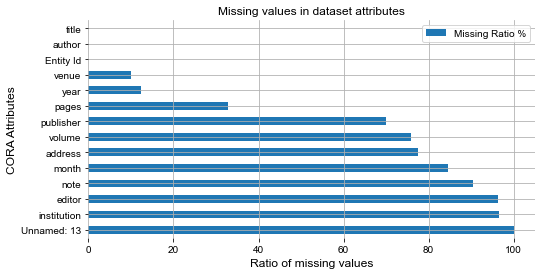

In [11]:
na_df = (dataset.isnull().sum() / len(dataset)) * 100      
na_df = na_df.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
fig = missing_data.plot(kind = "barh", figsize=(8, 4)).get_figure()
plt.style.use('seaborn-white') # plot style
plt.title("Missing values in dataset attributes")
plt.ylabel(dataset_name+' Attributes', fontsize=12)
plt.xlabel('Ratio of missing values', fontsize=12)
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.show()

## Data set shuffle (Optional)

In [12]:
dataset_shuffled = dataset.sample(frac=1).reset_index(drop=True)

## Pre-process

In [13]:
fields = [
     'author',
     'title',
]

# name of the id column
id_column_name = 'Entity Id'

# dataset
data, true_matrix = process_dataset(dataset, dataset_ground_truth, fields, id_column_name)

Creating groundtruth matrix: 100%|██████████| 17184/17184 [00:01<00:00, 11892.26it/s]


__Clique construction for visualization purposes__

In [14]:
labels_groundTruth, numOfObjWithoutDups, groups = create_true_labels(dataset[id_column_name].tolist(),dataset_ground_truth)            
data_length = [ len(x) for x in data ]

## Attributes

In [15]:
specs = {
    'Objects without any duplicates' : dataset.shape[0] - sum([len(x) for x in groups]), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : dataset.shape[0], 
    'Mean size of clusters' : np.average([len(x) for x in groups]),
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length),
    'Median length' : np.median(data_length)
}
dataset_specs = pd.DataFrame(list(specs.items()), columns=['Spec','#count'])
dataset_specs[['#count']] = dataset_specs[['#count']].astype(int)
dataset_specs

,Spec,#count
0,Objects without any duplicates,19
1,Objects with at least one duplicate,1276
2,Total number of objects,1295
3,Mean size of clusters,13
4,Number of ER clusters,93
5,Dataset size,1295
6,Average length,90
7,Min length,30
8,Max length,314
9,Median length,89


In [16]:
list(dataset.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

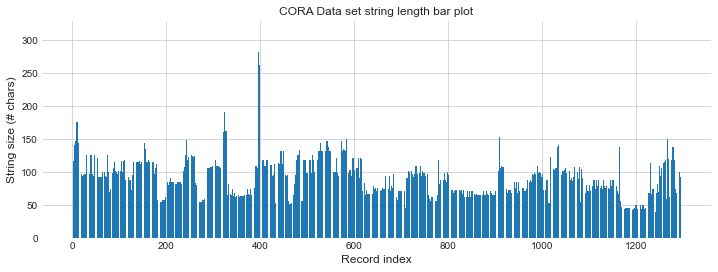

In [17]:
fig = plt.figure(figsize=(12,4))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index", fontsize=12)
plt.ylabel("String size (# chars)", fontsize=12)
plt.title(dataset_name + " Data set string length bar plot")
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
fig.savefig("./results/"+dataset_name.lower()+"/string_size_"+dataset_name+".png")
plt.show()

# __WinnER model__

WinnER framework has the bellow parameters (and their default values):
```
max_num_of_clusters = None, 
max_dissimilarity_distance = None, 
window_size = None,   
number_of_permutations = 1, 
char_tokenization = True,
embedding_distance_metric = 'euclid_jaccard', 
metric = 'kendal', 
similarity_vectors = 'ranked', 
distance_metric = 'euclid_jaccard', 
prototypes_optimization_thr = None, 
ngrams = None, 
similarity_threshold = None, 
num_of_threads = 16,
verbose_level=0, 
rbo_p = 0.7, 
wta_m = 1, 
max_num_of_comparisons = 250000, 
disable_tqdm = False,
enable_blocking = True,
debug_stop = None
```

although, the mandatory and the five official hyper-parameters are:

```
max_num_of_clusters, max_dissimilarity_distance, window_size, number_of_permutations = 1, similarity_threshold
```


## Usage example with the 5 hyper-parameters


#####################################################################
#                           .~  WinnER  ~.                          #
#####################################################################

Tokenization initialized with.. 
- Q-gramms:  3
- Char-Tokenization:  True
- Text cleanning process:  None

Processing strarts.. 
- Data size:  1295


Processing..: 100%|██████████| 1295/1295 [00:00<00:00, 33131.98it/s]




String positions are:
[   0    1    2 ... 1292 1293 1294]


###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Prototype optimization: 100%|██████████| 300/300 [00:00<00:00, 2911.47it/s]

Prototypes before:
[0, 3, 4, 7, 9, 12, 14, 18, 20, 22, 24, 26, 29, 31, 34, 36, 38, 41, 45, 48, 50, 51, 53, 54, 56, 59, 62, 64, 67, 72, 73, 74, 76, 78, 80, 81, 82, 84, 86, 88, 92, 94, 98, 99, 101, 103, 106, 108, 111, 114, 116, 119, 120, 127, 128, 130, 133, 135, 138, 148, 150, 153, 155, 157, 161, 163, 165, 168, 170, 173, 174, 176, 178, 180, 186, 194, 198, 200, 202, 205, 207, 209, 213, 214, 232, 235, 237, 239, 240, 242, 244, 246, 250, 252, 254, 257, 260, 261, 265, 266, 267, 269, 276, 283, 284, 286, 291, 295, 298, 304, 307, 310, 313, 315, 316, 320, 323, 325, 328, 330, 332, 334, 336, 339, 341, 343, 345, 350, 355, 361, 367, 369, 371, 373, 375, 377, 379, 381, 383, 386, 388, 389, 394, 396, 397, 398, 399, 401, 404, 406, 408, 419, 421, 425, 427, 429, 431, 434, 435, 437, 438, 440, 442, 446, 448, 449, 452, 456, 458, 460, 464, 466, 468, 471, 474, 475, 479, 483, 485, 489, 493, 500, 502, 504, 507, 509, 510, 512, 514, 518, 520, 521, 522, 525, 527, 529, 532, 534, 539, 544, 546, 549, 551, 555, 557, 559,


176  ->  m feder y freund and y mansour optimal universal learning and prediction of probabilistic concepts
434  ->  y freund and y mansour learning under persistent drift
435  ->  goldman s rivest r and schapire r learning binary relations and total orders
180  ->  yoav freund and robert e schapire adaptive game playing using multiplicative weights games and economic behavior
53  ->  n cesabianchi y freund d p helmbold and m warmuth online prediction and conversion strategies
54  ->  cesabianchi n freund y helmbold online prediction and conversion strategies in proceedings of the first eurocolt workshop
437  ->  sally a goldman ronald l rivest and robert e schapire learning binary relations and total orders
440  ->  goldman s kearns m  schapire r exact identification of circuits using fixed points of amplification functions
186  ->  freund y boosting a weak learning algorithm by majority
320  ->  y freund and d ron learning to model sequences generated by switching distributions
323 

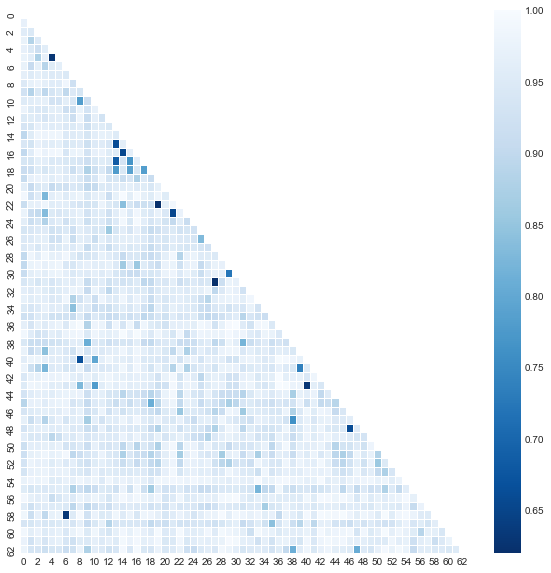


- Mean variance in prototype selection:  0.9306543477914498

- Final number of prototypes:  63

# Finished in 165183 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings: 100%|██████████| 1295/1295 [00:02<00:00, 529.46it/s]


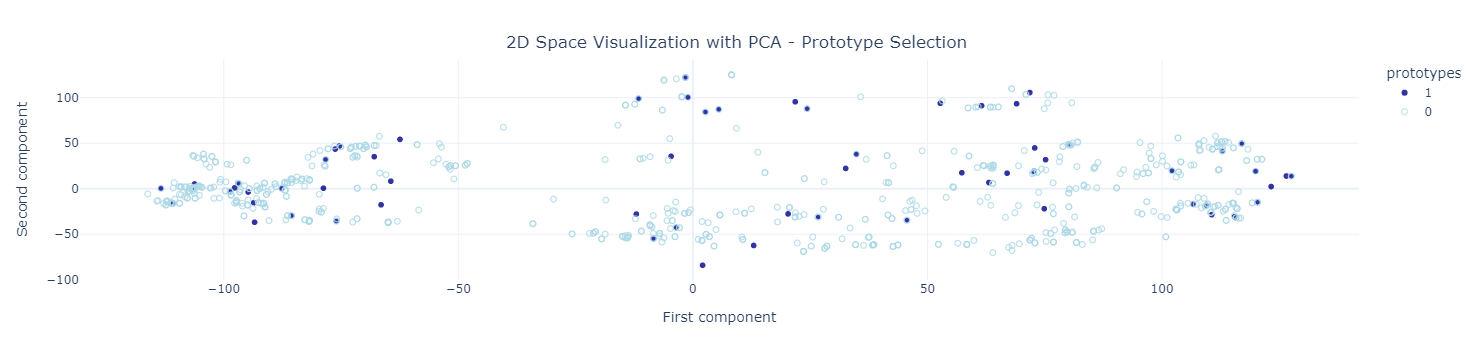


# Finished in 165183 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:
[[ 1 46 36 ... 61 53 58]
 [30 15  1 ... 52 32 17]
 [29 17  1 ... 55 33 10]
 ...
 [14 36 58 ... 60 40 54]
 [26 53 52 ... 55 42 54]
 [26 53 52 ... 55 42 54]]
- Similarity mapping in a matrix
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
Total comparisons:  835235
 -> between same objects:  17085
 -> between same objects with success:  14868
 -> between different objects:  818150
 -> between different objects with success:  812466

# Finished in 165183 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

####################

In [19]:
winner = WinnER(
    max_num_of_clusters = 300,
    max_dissimilarity_distance = 0.6,
    window_size = 10,
    similarity_threshold = 0.7,
    number_of_permutations = 1,
    verbose_level=2,
    enable_blocking = False
)

winner.ground_truth(dataset_ground_truth, true_matrix)
winner.fit(data)


acc,f1,precision,recall = winner.evaluate(winner.mapping_matrix, true_matrix, with_confusion_matrix=False)